In [1]:
import xarray as xr
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import rioxarray
from pathlib import Path
import pyproj
import scipy
from scipy.signal import savgol_filter
from dask.distributed import Client
import dask

In [2]:
client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62509,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:62520,Total threads: 2
Dashboard: http://127.0.0.1:62523/status,Memory: 10.67 GiB
Nanny: tcp://127.0.0.1:62513,


In [74]:
ds = xr.tutorial.open_dataset(
    "air_temperature",
    chunks={
        "lat": 25,
        "lon": 25,
        "time": -1,
    },  # this tells xarray to open the dataset as a dask array
)
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [ ]:
ds.air.chunks

In [4]:
testfile = Path("/Volumes/FIREICE/fihyper/cwaigl/20200830_BC/02_intermediate/brefcor/20200830-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
testdata = rioxarray.open_rasterio(testfile, chunks=(-1, 256, 256), default_name="reflectance")

In [5]:
testdata['long_name'] = "spectral reflectance, %*100"
testdata['name'] = testdata['long_name']
testdata.attrs['long_name'] = str(testdata.long_name.values)
testdata.attrs['name'] = str(testdata.long_name.values)

In [6]:
testdata.attrs['coordinate_system_string']

'PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-147.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'

In [7]:
testdata

<xarray.DataArray 'reflectance' (band: 459, y: 8506, x: 1226)>
dask.array<open_rasterio-c151a3046721251589269491dc2bbd31<this-array>, shape=(459, 8506, 1226), dtype=int16, chunksize=(459, 256, 256), chunktype=numpy.ndarray>
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(459,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(459,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.354e+05 4.354e+05 ... 4.366e+05 4.366e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 0
    long_name    <U27 'spectral reflectance, %*100'
    name         <U27 'spectral reflectance, %*100'
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    _FillValue:                14000.0
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 spectral reflectance, %*100
    acquisition_time:          2020-08-30T23:08:24.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 435424.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1226
    sun_azimuth:               202.02
    sun_elevation:             31.880000000000003
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100] 
    name:                      spectral reflectance, %*100

In [8]:
crs = pyproj.CRS.from_wkt(testdata.attrs['coordinate_system_string'])
transformer = pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(4326), crs, always_xy=True) 
lonlat_to_crs = lambda lon, lat: transformer.transform(lon, lat)    

In [9]:
x, y = transformer.transform(-148.35, 64.7)

In [20]:
testdata.wavelength.sel(band=174)

<xarray.DataArray 'wavelength' ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    fwhm         float64 dask.array<chunksize=(), meta=np.ndarray>
    wavelength   float64 dask.array<chunksize=(), meta=np.ndarray>
    band         int64 174
    spatial_ref  int64 0
    long_name    <U27 'spectral reflectance, %*100'
    name         <U27 'spectral reflectance, %*100'

In [21]:
x, y

(435629.2061170959, 7175706.511372154)

In [22]:
def bin_df(specdf):
    if len(specdf % 2) == 1:
        even_df = specdf.iloc[:-1:2].reset_index(drop=True)
    else:
        even_df = specdf.iloc[::2].reset_index(drop=True)
    odd_df = specdf.iloc[1::2].reset_index(drop=True)
    return (even_df + odd_df)/2

In [25]:
mask = testdata.where(testdata != 14000).sel(band=1)

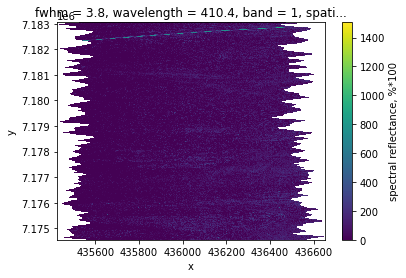

In [27]:
mask.plot()

In [32]:
mask

<xarray.DataArray 'reflectance' (y: 8506, x: 1226)>
dask.array<getitem, shape=(8506, 1226), dtype=float64, chunksize=(256, 256), chunktype=numpy.ndarray>
Coordinates:
    fwhm         float64 dask.array<chunksize=(), meta=np.ndarray>
    wavelength   float64 dask.array<chunksize=(), meta=np.ndarray>
    band         int64 1
  * x            (x) float64 4.354e+05 4.354e+05 ... 4.366e+05 4.366e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 0
    long_name    <U27 'spectral reflectance, %*100'
    name         <U27 'spectral reflectance, %*100'
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    _FillValue:                14000.0
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 spectral reflectance, %*100
    acquisition_time:          2020-08-30T23:08:24.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 435424.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1226
    sun_azimuth:               202.02
    sun_elevation:             31.880000000000003
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100] 
    name:                      spectral reflectance, %*100

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


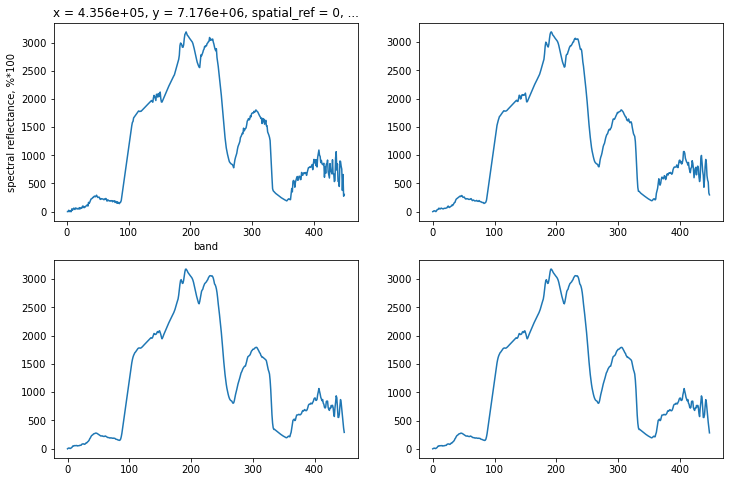

In [173]:
spec = testdata.sel(x=x, y=y, method='nearest')[:-10]
spec_bin = spec.values[::2]
wav_bin = testdata.band.values[:-10:2]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
print(ax)
spec.plot(ax=ax[0, 0])
ax[0, 1].plot(savgol_filter(spec.values, 7, 5))
ax[1, 0].plot(savgol_filter(spec.values, 7, 3))
ax[1, 1].plot(savgol_filter(spec.values, 7, 2))
#ax[1, 0].plot(wav_bin, spec_bin, )
#ax[1, 1].plot(wav_bin, savgol_filter(spec_bin, 9, 2))

In [65]:
str(testdata.long_name.values)

'BRDF-corrected BC flighltline #4, 2020-08-03'

In [104]:
savgol_filter(testdata.sel(x=x, y=y, method='nearest').values, 5, 2)

array([-7.71428571e-01,  6.08571429e+00,  1.03714286e+01,  1.33714286e+01,
        5.22857143e+00,  9.42857143e-01,  1.33714286e+01,  2.86000000e+01,
        3.88000000e+01,  4.19428571e+01,  5.81714286e+01,  5.14000000e+01,
        4.88000000e+01,  5.61142857e+01,  6.04000000e+01,  5.40571429e+01,
        5.02000000e+01,  4.82857143e+01,  5.52571429e+01,  5.70571429e+01,
        5.80857143e+01,  5.98000000e+01,  6.45142857e+01,  6.93714286e+01,
        8.61428571e+01,  9.45714286e+01,  7.97142857e+01,  7.42857143e+01,
        8.12857143e+01,  9.10857143e+01,  9.76571429e+01,  1.13028571e+02,
        1.06542857e+02,  1.23200000e+02,  1.38371429e+02,  1.58714286e+02,
        1.64857143e+02,  1.96942857e+02,  2.19057143e+02,  2.29971429e+02,
        2.39314286e+02,  2.47857143e+02,  2.57828571e+02,  2.67600000e+02,
        2.71400000e+02,  2.67200000e+02,  2.75685714e+02,  2.81742857e+02,
        2.70028571e+02,  2.52800000e+02,  2.53942857e+02,  2.54657143e+02,
        2.38085714e+02,  

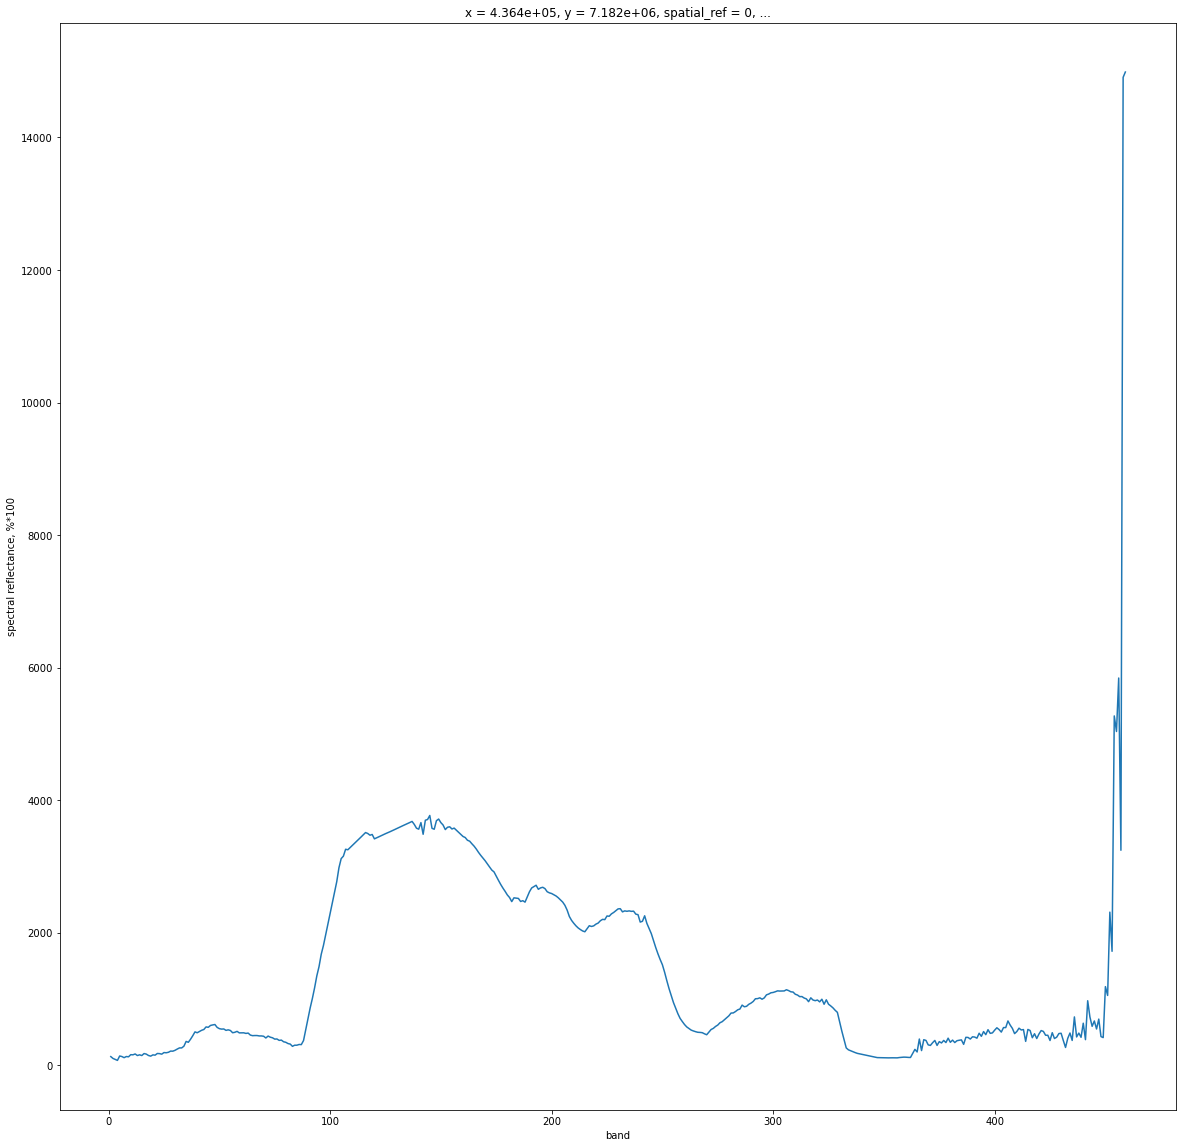

In [117]:
testdata.isel(x=1000, y=1000).plot(size=20, aspect=1)

In [169]:
testdata.sel(band=1).shape

(8506, 1226)

In [ ]:
da = xr.DataArray(
[[1,2,3],
       [4,5,6]],
dims=("x", "y"),
coords={"x": [0.5,1.5], "y": [2.5,1.5,0.5]},
)

d = {'geometry': [Polygon([(0, 0), (0,2), (2, 2), (2, 0)]),Polygon([(2,0),(2,2),(3,2),(3,0)])]}
gdf = gpd.GeoDataFrame(d)

zonal_stats(
    vectors=gdf,
    raster=da.values,
    affine=da.rio.transform(),
    stats=["mean","count"],
    all_touched=True,
)


/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'mean': 4.5, 'count': 2}, {'mean': 6.0, 'count': 1}]

(0.0, 4.0)

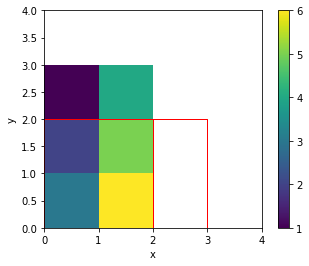

In [ ]:
#plotting to illustrate the data
fig, ax = plt.subplots()
da.plot(ax=ax,x="x",y="y")
gdf.boundary.plot(ax=ax, color='r', lw=1)
ax.set_xlim(0,4)
ax.set_ylim(0,4)

In [11]:
da.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, -1.0, 3.0)